In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk
import scipy 
import igraph
import ts2vg # Time series to visibility graphs
import scipy.spatial.distance as distance
import scipy
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import os 

#### Tasks para Mutual Information:
    1. Gerar redes contendo o mesmo número de arestas da rede Pearson
    2. Gerar redes com limiar baseado no maior diâmetro (e backbone associado)
    3. Gerar redes com limiar baseado nas maiores (1%) correlações (e backbone associado)
    4. Verificar as características de todas as redes e realizar a geração do shapefile

#### Funções e Classes

In [122]:
class threshold():
    # Remover arestas com peso abaixo de um dado threshold (valor real)
    # entrada: g, flow_threshold
    # retorno: g              
    def remove_edges(g, flow_threshold):
        del_edges = []
        for e in g.es():
            if e['weight'] < flow_threshold:
                del_edges.append(e)
        g.delete_edges(del_edges)
        return g

    # Função que varia o threshold e chama a função acima 
    # remover as arestas abaixo do threshold e em seguida verifica o diâmetro
    # Entrada: g
    # Retorno: threshold (valor real) associado ao maior diâmetro da rede
    def max_diameter_threshold(g):
        max_threshold = max(g.es['weight'])
        max_diameter = 0
        for t in np.arange(0.1, max_threshold, 0.01):
            #print(threshold)
            ng = g.copy()
            ng = threshold.remove_edges(ng, t)
            #print(ng)
            diameter = ng.diameter(directed=False)
            #print(diameter)
            if diameter > max_diameter:
                max_diameter = diameter
                threshold_max_diameter = t
        return threshold_max_diameter

def heterogeinity(degree):
    power_degree = [] # degree sequence 
    for i in degree:
        power_degree.append(i**2)
        hp = ( (sum(power_degree)/len(power_degree))/((sum(degree)/len(degree))**2) )
    return(hp)

def geographical_distance(adj,pos):
    """
    Parameters:
    -----------
        adj - pares de pontos que correspondem a um ponto (série temporal) disposta no espaço geográfico da 
        bacia do rio Tamanduateí.
        pos - índice (d,j) de cada ponto na matriz que representa o espaço geográfico.
        
    Returns:
    --------
        A distância euclidiana entre os pontos distribuídos na região analisada.
    """
    geo_dist = {}
    for i in adj: # i é o par formado pelos grafos 'a' e 'b'
        a = pos[i[0]] # busca as coordenadas (i,j) do grafo 'a' no vetor que guarda a posição das séries na matriz
        b = pos[i[1]] # busca as coordenadas (i,j) do grafo 'b' no vetor que guarda a posição das séries na matriz
        dist = np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
        geo_dist[i] = dist
    return(geo_dist)

def norm(data,dataType):
    """
    Parameters:
    -----------
        data: Lista ou dicionário
        dataType: Informa se o dado é do tipo lista (0), ou do tipo dicionário (1)
    
    Returns:
    --------
        Valores do vetor data entre o intervalo de 0 e 1.
    
    """
    if (dataType == 0):
        n = [];
        max_value = max(data);
        min_value = min(data);
        for i in range(len(data)):
            n.append((data[i]-min_value)/(max_value - min_value));
    else:
        n = {};
        max_value = max(list(data.values()));
        min_value = min(list(data.values()));
        for i in data:
            n[i] = (data[i]-min_value)/(max_value - min_value);
            
    return(n)

class reading():
    
    def files_and_validation():
        """
        Returns:
        --------
            Realiza a leitura dos arquivos contendo as matrizes de dados. Os dados inválidos das matrizes (-99) são
            removidos, gerando vetores com apenas os valores válidos.
            data ==> Vetor contendo apenas os valores válidos das matrizes
            pos ==> Vetor contendo a posição que os valores válidos ocupam na matriz de dados original
        """
        files_list = os.listdir('data-01-original');
        files_list.sort();
        data = [];
        for i in range(len(files_list)):
            m = np.genfromtxt('data-01-original/'+str(files_list[i]));
            validated = [];
            pos = [];
            for row in range(len(m[:,0])):
                for column in range(len(m[0,:])):
                    if (m[row][column] != -99):
                        validated.append(m[row,column]);
                        pos.append([row,column]);
            data.append(validated);
                    
        return(data,pos);

    def timeSeriesGeneration(validated_data):
        """
        Parameters:
        -----------
            Arrays unidimensionais contendo os valores estimados das previsões
        Returns:
        --------
            Série temporal associada a cada ponto válido (diferente de -99).
            A série temporal 0 será composta por todos os valores na posição 0 dos 4464 arrays, e assim
            em diante. O resultado são 587 séries temporais de tamanho 4464.
        """
        time_series = {};
        for i in range(len(validated_data[0])):
            s = np.empty((0,0));
            for j in range(len(validated_data)):
                s = np.append(s,validated_data[j][i]);
            time_series[i] = s;
        
        for t in range(len(time_series)):
            for k in range(len(time_series[0])):
                if (time_series[t][k] < 20):
                    time_series[t][k] = 0;
                
        return(time_series);
        
class comparing():
    
    def __init__(self, graph_metrics):
        """
        Parameters:
        -----------
            Array de métricas que será usado como parâmetro para o restante das funções dessa classe.
            São recebidos tanto os feature arrays, com métricas combinadas, quanto os sequence arrays, como é
            o caso da sequência de graus.
            As métricas enviadas são as pertencentes a todos os grafos. Sendo assim, self.metrics_array
            receberá um array de tamanho 587, onde cada posição terá um array de métricas correspondente a
            um grafo.
            As funções de distância/similaridade irão computar a medida entre todos os pares (a,b) de métricas,
            com a e b variando de 0 até 586, apenas desconsiderando casos como: 
                - a = b
                - (b,a) se já existir um valor calculado para o par (a,b)
        """
        self.metrics_array = graph_metrics
    
    def jensenshannon(self):
        """
        Returns:
        --------
            Retorna a o valor da distância de Jensen-Shannon, no formato de um dicionário, entre todos os 
            pares de grafos.
            A função computa a raiz quadrada da divergência de Jensen-Shannon:
                JSD(P||Q) = ((D(P||M) + D(Q||M))/2)^(1/2)
                Onde:
                    D é a divergência de Kullback-Leibler 
                    M = (P + Q)/2 
        
        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2205.
                
        """
        jensenshannon_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                jensenshannon_dist[i,j] = distance.jensenshannon(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(jensenshannon_dist)    
    
    
    def euclidean(self):
        """
        Returns:
        --------
            Retorna a o valor da distância Euclidiana, no formato de um dicionário, entre todos os 
            pares de grafos.
            Considerando os vetores, a e b, a distância euclidiana é calculada como:
                e_dist(a,b) = ||a - b||
        
        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2204-2205.
            
        """
        euclidean_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                euclidean_dist[i,j] = distance.euclidean(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(euclidean_dist)

    def manhattan(self):
        """    
        Returns:
        --------
            Retorna a o valor da distância de Manhattan (Cityblock), no formato de um dicionário, entre 
            todos os pares de grafos.
            Considerando os vetores a e b, a distância de manhattan é calculada como:
                m_dist(a,b) = Σ(|ai - bi|)
                i deve ser iterado a fim de percorrer todos os elementos de cada vetor.

        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2203.
        """
        manhattan_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                manhattan_dist[i,j] = distance.cityblock(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(manhattan_dist)

    def canberra(self):
        """   
        Returns:
        --------
            Retorna a o valor da distância de Canberra, no formato de um dicionário, entre 
            todos os pares de grafos.
            Considerando os vetores a e b, a distância de canberra é calculada como:
                c_dist(a,b) = Σ((|ai - bi|)/(|ai|+|bi|))
                i deve ser iterado a fim de percorrer todos os elementos de cada vetor

        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2202.
        """
        canberra_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                canberra_dist[i,j] = distance.canberra(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(canberra_dist)

    def cosine(self):
        """    
        Returns:
        --------
            Retorna a o valor da distância baseada em cosseno, no formato de um dicionário, entre 
            todos os pares de grafos.
            Considerando os vetores a e b, o cosseno entre esses dois vetores pode ser obtido pela
            seguinte relação:
                cos(θ) = (a·b)/(||a||*||b||)
                cos_dist = 1 - cos(θ)

                (a·b) é o produto escalar entre os dois vetores.
                
        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2204.
        """
        cosine_sim = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                cosine_sim[i,j] = distance.cosine(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(cosine_sim)

def mutual_information(ts):
    """
    Parameters:
    -----------
        ts - Conjunto de séries temporais lidas inicialmente. Cada série é comparada com todas as outras usando 
        mutual information. 
    Returns:
    --------
        mi_dict - Retorna um dicionário. As chaves correspondem às séries e os valores são a distância geográfica e
        a informação mútua
    """    
    mi_dict = {};
    ctrl = 1;
    for i in range(len(ts)):
        for j in range(ctrl,len(ts)):
            mi = sk.normalized_mutual_info_score(ts[i], ts[j], average_method='arithmetic');
            mi_dict[i,j] = [geo_dist[i,j],mi];
        ctrl += 1;
    return(mi_dict);

def g_graph(data):
    """
    Parameters:
    -----------
        data - Dicionário contendo os pares de séries temporais e seus respectivos pesos. Cada par presente no 
        dicionário representa uma conexão entre dois nós da rede.
    Returns:
    --------
        plt - Contém o plot do grafo
        gr - Variável contendo o objeto grafo do tipo igraph 
    """
    gr = igraph.Graph();
    gr.add_vertices(587); # Valor estático. O número de nós na rede geográfica é constante.
    gr.add_edges((list(data.keys())));
    gr.vs['x'] = [position[i][1] for i in range(587)];
    gr.vs['y'] = [position[j][0] for j in range(587)];
    gr.es['weight'] = [i[1] for i in list(data.values())];
    lyt = [];
    for i in range(587):
        lyt.append( (gr.vs[i]['x'],gr.vs[i]['y']) );
    visual_style = {};
    visual_style['layout'] = lyt;
    visual_style['bbox'] = (500,500);
    visual_style['margin'] = 20;
    visual_style['vertex_size'] = 5;
    visual_style['edge_width'] = 1.5;
    plt = igraph.plot(gr,**visual_style);
    #igraph.plot(gr,'basin-region-js-0dot358.png',**visual_style);
    return(plt,gr); #plot object and the graph itself

#def strength_vertex(g,i):
#    strength_list = g.strength(weights=g.es['weight']) # lista com o strength de todos os nós da rede
#    return(strength_list[i])

def backbone(g,alpha):
    # pij = (1 - (wij/si))**(ki - 1), onde:
    # w --> weight
    # s --> strength
    # k --> degree
    p={}
    adj = g.get_adjacency()
    n_nodes = g.vcount()
    strength_vertex = g.strength(weights=g.es['weight'])
    for i in range(n_nodes):
        for j in range(n_nodes):
            if (adj[i,j] == 1): # verificando se há conexão entre o par i,j
                w = g.es[g.get_eid(i,j)]['weight']
                s = strength_vertex[i] # calcula o strength de toda a rede e retorna apenas para o nó desejado
                k = g.vs[i].degree()
                pij = (1 - (w/s))**(k-1)
                if (pij < alpha): # aplicando a relação com o alpha
                    p[i,j] = [pij,w]

    # Pegando os pares simétricos e atribuindo -99 ao par com maior valor de probabilidade
    for i in p:
        if ((i[0],i[1]) and (i[1],i[0])) in p.keys():
            if p[i[0],i[1]][0] <= p[i[1],i[0]][0]:
                p[i[1],i[0]][0] = -99
            else:
                p[i[0],i[1]][0] = -99

    # Criando dicionário com os pares válidos
    bb = {}
    for i in p:
        if not (p[i][0] == -99):
            bb[i] = p[i]

    return(bb)

#### Leitura das séries temporais

In [5]:
# Estimated execution time: 24s
init = time.time()

# Time series
validated_files,position = reading.files_and_validation() # removing -99 values and saving the position of the valid points in a dictionary
meteorological_time_series = reading.timeSeriesGeneration(validated_files)

end = time.time()
print(end-init)

43.727715730667114


In [6]:
# Geographical distance between all pairs
c = 1;
keys = {};
for i in range(len(meteorological_time_series)):
    for j in range(c,len(meteorological_time_series)):
        keys[i,j] = (i,j);
    c+=1;
geo_dist = (geographical_distance(list(keys.keys()),position));

In [7]:
# Execution time: 300s
i = time.time();
mutual_inf_all_edges = mutual_information(meteorological_time_series);
e = time.time();
print(e-i);

305.02690982818604


### Full Graph

In [57]:
g_graph_full = g_graph(mutual_inf_all_edges)

---
### Thresholds
    1. Limiar para produção de ~1270 arestas (mesmo número de arestas da rede GT-Pearson)
    2. Limiar baseado no maior diâmetro 
    3. Limiar baseado nas maiores correlações (1%)

#### Limiar para 1270 arestas

In [8]:
mi_1270_edges = {}
for i in mutual_inf_all_edges:
    if mutual_inf_all_edges[i][1] >= 0.5833:
        mi_1270_edges[i] = mutual_inf_all_edges[i]

---
#### Limiar baseado no maior diâmetro

In [9]:
full_graph = igraph.Graph()
full_graph.add_vertices(587)
full_graph.add_edges(mutual_inf_all_edges)
full_graph.es['weight'] = np.array(list(mutual_inf_all_edges.values()))[:,1]
mi_threshold_diameter = {}
thrshld_diameter = threshold.max_diameter_threshold(full_graph)
for keys in mutual_inf_all_edges:
    if mutual_inf_all_edges[keys][1] >= thrshld_diameter:
        mi_threshold_diameter[keys] = mutual_inf_all_edges[keys]

---
#### Limiar baseado nas maiores correlações

In [10]:
mi_all_edges_items = np.array(list(mutual_inf_all_edges.items()))
mi_all_edges_items = mi_all_edges_items[mi_all_edges_items[:,1,1].argsort()]

In [11]:
mutual_inf_all_edges_sorted_values = {}
mutual_inf_all_edges_sorted_keys = {}
for i in range(len(mi_all_edges_items)):
    mutual_inf_all_edges_sorted_keys[i] = [int(mi_all_edges_items[i,0,0]),int(mi_all_edges_items[i,0,1])]
    mutual_inf_all_edges_sorted_values[i] = mi_all_edges_items[i,1].tolist()

In [19]:
int(len(mutual_inf_all_edges_sorted_values)*0.01)+1

1720

In [20]:
mutual_inf_max_corr = {}
for i in range((len(mutual_inf_all_edges_sorted_values)-1),(len(mutual_inf_all_edges_sorted_values) - int(len(mutual_inf_all_edges_sorted_values)*0.01+2)),-1):
        mutual_inf_max_corr[mutual_inf_all_edges_sorted_keys[i][0],mutual_inf_all_edges_sorted_keys[i][1]] = mutual_inf_all_edges_sorted_values[i]

---
### Geração das redes

In [120]:
# 1270 edges
g_graph_1270 = g_graph(mi_1270_edges)
g_graph_1270[1].write_graphml('g_graph_1270_edges_threshold_MI')

# threshold defined by the maximum diameter
g_graph_max_diameter = g_graph(mi_threshold_diameter)
g_graph_max_diameter[1].write_graphml('g_graph_max_diameter_threshold_MI')

# threshold defined by the highest correlation (1%)
g_graph_highest_corr = g_graph(mutual_inf_max_corr)
g_graph_highest_corr[1].write_graphml('g_graph_1_highest_corr_threshold_MI')

In [64]:
print("g_graph_1270 - Edges:",g_graph_1270[1].ecount())
print("g_graph_max_diameter - Edges:",g_graph_max_diameter[1].ecount())
print("g_graph_highest_corr - Edges:",g_graph_highest_corr[1].ecount())

g_graph_1270 - Edges: 1270
g_graph_max_diameter - Edges: 964
g_graph_highest_corr - Edges: 1720


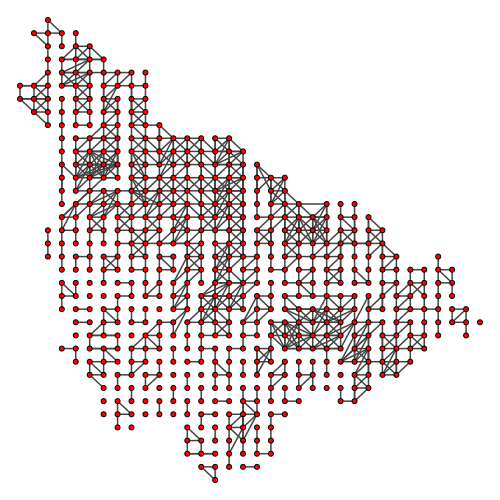

In [151]:
# Rede cujo limiar foi estabelecido para obter o mesmo número de arestas observado na rede GT-Network (Pearson)
g_graph_1270[0]

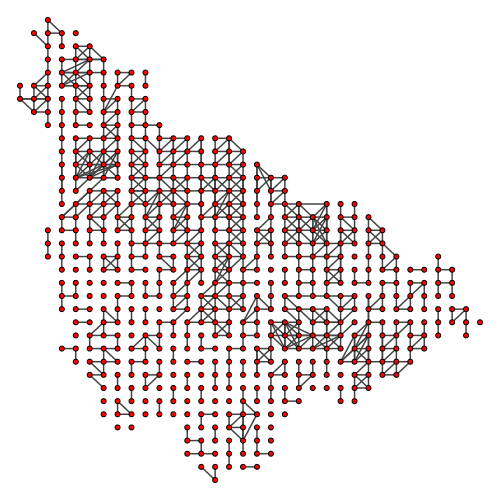

In [152]:
# Rede cujo limiar foi estabelecido de acordo com a relação entre o valor de MI e o diâmetro da rede
g_graph_max_diameter[0]

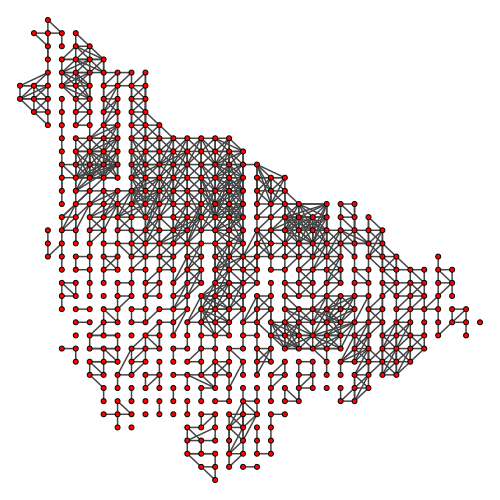

In [153]:
# Rede cujo limiar foi estabelecido através de 1% das maiores correlações
g_graph_highest_corr[0]

---
### Backbone para cada rede

In [154]:
i = time.time()
# Desired number of edges: 1270 
backbone_1270 = backbone(g_graph_full[1],0.1272)

# Desired number of edges: 964
backbone_max_diameter = backbone(g_graph_full[1],0.1124)

# Desired number of edges: 1720
backbone_highest_corr = backbone(g_graph_full[1],0.14254)
e = time.time()
print(e-i,'s')

3.6160855293273926 s


---
### Redes Backbone


In [143]:
# Desired number of edges: 1270 
g_graph_backbone_1270 = g_graph(backbone_1270)

# Desired number of edges: 964
g_graph_backbone_max_diameter = g_graph(backbone_max_diameter)

# Desired number of edges: 1720
g_graph_backbone_highest_corr = g_graph(backbone_highest_corr)

---
### Metrics